# Фильтр Калмана


В этой блокноте будут рассмотрены следующие темы:
- Введение в фильтр Калмана.
- Компоненты модели и предположения.
- Алгоритм фильтра Калмана.
- Применение к статическим и динамическим одномерным данным.
- Применение к многомерным данным.

In [3]:
# Imports
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
np.random.seed(0) # for reproducibility

---

## Что такое фильтр Калмана?

- Фильтр Калмана (KF) — это алгоритм, который использует ряд измерений, наблюдаемых в течение времени, содержащий статистический шум и другие неточности.
- Он производит оценки неизвестных переменных, которые, как правило, более точны, чем те, которые основаны только на измерениях.
- Разработан Рудольфом Э. Калманом в конце 1950-х годов.
- Приложения:
  - отслеживание объектов (проект Apollo, GPS, беспилотные автомобили).
  - обработка изображений.
  - экономическое и финансовое моделирование.

### Теоретические основы

- Динамические системы — это системы, которые изменяются со временем.
- Они описываются набором уравнений, которые предсказывают будущее состояние системы на основе ее текущего состояния.
- KF предполагает, что система является *линейной* динамической системой с *гауссовым* шумом.
- Гауссовские распределения используются из-за их хороших свойств при работе со средними значениями и дисперсиями.

### Каковы ингредиенты?

**Состояние**
- Истинное значение переменных, которые мы хотим оценить.
- Вектор состояния представляет всю информацию, необходимую для описания текущего состояния системы.

**Модель наблюдения**
- Связывает текущее состояние с измерениями или наблюдениями.

**Зашумленные измерения**
- Шум процесса и шум измерения (предполагается, что он гауссовский) представляют неопределенность в наших моделях и измерениях.

Пример:
- Автомобиль движется с постоянной скоростью.
- Модель: Положение автомобиля = скорость $\times$ время $+$ шум системы.
- Измерения: положение и скорость (которые также являются шумными).

### Роль шума

Компромисс между влиянием модели и измерениями определяется шумом.

- Если модель имеет относительно большие ошибки, большее значение придается последним измерениям при вычислении текущей оценки.
- Если измерение имеет большие ошибки, большее значение придается модели при выполнении текущей оценки.
- Следовательно, вам необходимо оценить не только свое состояние, но и ошибки (ковариацию) как для модели, так и для измерений.
- Они также должны обновляться на каждом временном шаге.

### Стратегия обновления

ФК — это рекурсивный алгоритм:

- Использует информацию из предыдущего временного шага для обновления оценок.
- Не хранит в памяти все полученные на данный момент данные.
- Имеет структуру предиктора-корректора:
- Делает прогноз на основе модели.
- Обновляет прогноз с помощью измерений.
- Повторяет.

### Основные предположения

Подход фильтра Калмана основан на трех основных предположениях:

1. Система может быть описана или аппроксимирована линейной моделью.
2. Весь шум (как от системы, так и от измерений) является белым, т. е. значения не коррелируют.
3. Весь шум является гауссовым.

#### Предположение 1: линейность

Каждая переменная в текущий момент времени является линейной функцией переменных в предыдущие моменты времени.

- Многие системы можно аппроксимировать таким образом.
- Линейные системы легко анализировать.
- Нелинейные системы часто можно аппроксимировать линейными моделями вокруг текущей оценки (расширенный KF).

#### Предположение 2: Белизна

Значения шума не коррелируют во времени.

- Если вы знаете шум в момент времени $t$, это не поможет вам предсказать шум в будущие моменты времени $t+\tau$.
- Белый шум является разумным приближением к реальному шуму.
- Предположение делает математику понятной.

> **📝 Примечание** Белый шум содержит смесь всех различных частот с одинаковой интенсивностью, смешанных вместе.
>
> Это похоже на то, как белый свет содержит все цвета радуги вместе.

#### Предположение 3: Гауссовский шум

В любой момент времени плотность вероятности шума является гауссовой.

- Системный и измерительный шум часто являются комбинацией множества небольших источников шума.
- Эффект этой комбинации приблизительно гауссовский.
- Если известны только среднее значение и дисперсия (типичный случай в инженерных системах), гауссовское распределение является хорошим выбором, поскольку эти две величины полностью определяют гауссовское распределение.
- Гауссово распределение имеет хорошие свойства и его легко обрабатывать математически.

---

## Технические подробности

### Объединение двух источников

Предположим, что автомобиль имеет определенное начальное положение $x_0=0$ и начальную скорость $\dot{x}_0=60 км/ч$.

Если скорость постоянна, то имеем:

$$x_{t} = 1\cdot x_{t-1} + \delta t \cdot \dot{x}_{t-1}$$
$$\dot{x}_{t} = 0 \cdot x_{t-1} + 1 \cdot \dot{x}_{t-1}$$

В матричной форме:

$$ \boldsymbol{x}_{t} =
\begin{bmatrix}
x_{t} \\
\dot{x}_{t}
\end{bmatrix}
=
\begin{bmatrix}
1 & \delta t \\
0 & 1
\end{bmatrix}
\begin{bmatrix}
x_{t-1} \\
\dot{x}_{t-1}
\end{bmatrix} = \mathbf{A} \boldsymbol{x}_{t-1}
$$

<img src="data\l6\system.png" style="ширина: 50%; дисплей: блок; поле: авто;">

- Текущее положение и скорость будут меняться в соответствии с этой простой динамической системой

$$\boldsymbol{x}_{t} = \mathbf{A} \boldsymbol{x}_{t-1} + \boldsymbol{w}_{t-1}$$

- где $\boldsymbol{w}_t \sim \mathcal{N}(0,\mathbf{Q})$ представляет возмущения в базовых динамических системах (например, ямы на дороге).
- $\boldsymbol{x}_{t} \in \mathbb{R}^{N}$ представляет состояние системы.
- $\mathbf{Q} \in \mathbb{R}^{N \times N}$ - это *ковариация шума процесса*, где $N$ представляет количество переменных состояния (в нашем случае 2, положение и скорость).

Где будет машина через 1 минуту?

Если мы полагаемся только на нашу простую систему $\boldsymbol{x}_{t+1} = \mathbf{A} \boldsymbol{x}_{t}$, даже не принимая во внимание шум, машина будет продолжать движение со скоростью $60 км/ч$ и будет на расстоянии $1 км$.

<img src="data\l6\model_pred.png" style="width: 50%; display: block; margin: auto;">

Допустим, в нашей машине есть GPS.
- Как и все приборы, наш GPS подвержен ошибкам и дает нам неточные измерения.
- Кроме того, наш GPS может измерять только местоположение, но не скорость.
- Согласно нашему GPS, через 1 минуту мы находимся в $0,8 км$ от того места, где мы начали.

<img src="data\l6\gps.png" style="width: 50%" align="center">

- Пусть мера нашего GPS будет

$$\boldsymbol{z}_t = \mathbf{H} \boldsymbol{x}_t + \boldsymbol{v}_t$$

- где $\boldsymbol{v}_t \sim \mathcal{N}(0,\mathbf{R})$ представляет неопределенность в измерениях.
- $\boldsymbol{z}_{t} \in \mathbb{R}^{M}$ - вектор измерений.
- В нашем случае, поскольку GPS измеряет только положение, мы имеем $\mathbf{H} = \begin{bmatrix} 1 & 0 \end{bmatrix}$ и $\mathbf{R} = \begin{bmatrix} r_{xx} \end{bmatrix}$.

- В общем случае $\mathbf{H} \in \mathbb{R}^{M,N}$ представляет собой матрицу, которая отображает $N$ переменных состояния в $M$ измерений, а $\mathbf{R} \in \mathbb{R}^{M,M}$ представляет собой ковариацию шума измерений.

Подводя итог, у нас есть два разных источника информации:
- линейное стохастическое разностное уравнение, представляющее наши неточные знания о дискретно-временном контролируемом процессе;
- источник измерений, которые являются шумными.

<img src="data\l6\inputs.png" style="width: 20%; display: block; margin: auto;">

Как нам объединить их, чтобы получить наилучшую возможную оценку наших системных переменных?

### Алгоритм KF

KF — это интерактивная процедура, состоящая из двух шагов:

- **Предсказать** (обновление времени)
- **Исправить** (обновление измерения)

Эти два шага используются для обновления двух величин:
- **Оценка состояния**.
- Неопределенность нашей оценки состояния, называемая **оценкой ковариации**.

Прежде чем рассматривать итеративную процедуру, давайте введем эту вторую величину.

**Оценка ковариации**

Существует два источника ошибок в оценке состояния нашей системы.

- *Априорная* ошибка оценки $e^{-}_t = x_t - \hat{x}^{-}_t$.

- *Апостериорная* ошибка оценки $e_t = x_t - \hat{x}_t$.

Где:
- $\hat{x}^{-}_t$ - оценка состояния, основанная только на знании системы, например, уравнениях динамики.
- $\hat{x}_t$ - оценка, основанная также на измерении $z_t$, например, GPS.

Каждый тип ошибки связан с ковариационной матрицей, которая отражает величину неопределенности в оценках состояния.

- $\mathbf{P}_t^{-} = \mathbb{E}[e^{-}_t e^{-T}_t] \in \mathbb{R}^{N\times N}$ (*априорная* оценка ковариации).
- $\mathbf{P}_t = \mathbb{E}[e_t e^{T}_t] \in \mathbb{R}^{N\times N}$ (*апостериорная* оценка ковариации).
- В нашем случае имеем $\mathbf{P}_t = \begin{bmatrix} p_{xx} & p_{\dot x x} \\ p_{\dot x x} & p_{\dot x \dot x} \end{bmatrix}$ (для удобства чтения индекс $t$ у элементов матрицы опущен):
- $p_{xx}$ - неопределенность положения;
- $p_{\dot x \dot x}$ - неопределенность скорости;
- $p_{x \dot x}$ и $p_{\dot x x}$ представляют собой корреляцию между шумом в измерениях положения и скорости.
- $\mathbf{P}_t^{-}$ имеет тот же вид.

#### Прогноз

- Уравнения динамики отвечают за проекцию вперед (во времени) текущего состояния и оценок ковариации ошибок для получения *предшествующей* оценки для следующего временного шага.
- Такие уравнения обновления времени также можно рассматривать как *уравнения предиктора*.

Обновление оценки состояния:

$$\hat{\boldsymbol{x}}_{t}^{-} = \mathbf{A} \hat{\boldsymbol{x}}_{t-1}$$

<img src="data\l6\model_pred (1).png" style="width: 50%; display: block; margin: auto;">

Обновление оценки ковариации:

$$
\begin{aligned}
\mathbf{P}_{t}^{-} &= \mathbb{E}[e^{-}_t e^{-T}_t] \\
  &= \mathbb{E}[(\boldsymbol{x}_{t} - \hat{\boldsymbol{x}}^{-}_{t})(\boldsymbol{x}_{t} - \hat{\boldsymbol{x}}^{-}_{t})^T] \\
  &= \mathbb{E}[(\mathbf{A} \boldsymbol{x}_{t-1} + \boldsymbol{w} - \mathbf{A} \hat{\boldsymbol{x}}_{t-1})(\mathbf{A} \boldsymbol{x}_{t-1} + \boldsymbol{w} - \mathbf{A} \hat{\boldsymbol{x}}_{t-1})^T] \\
  &= \mathbb{E}[(\mathbf{A}e_{t-1})(e_{t-1}^T \mathbf{A}^T)] + \mathbb{E}[\boldsymbol{w}\boldsymbol{w}^T]\\
  &= \mathbf{A}\mathbb{E}[e_{t-1}e_{t-1}^T ]\mathbf{A}^T + \mathbf{Q} \\
  &= \mathbf{A}\mathbf{P}_{t-1}\mathbf{A}^T + \mathbf{Q}
\end{aligned}
$$

Подводя итог, шаг Predict состоит из двух уравнений для обновления:
- Оценка состояния.
- Оценка ковариации.

<img src="data\l6\update.png" style="width: 20%; display: block; margin: auto;">

#### Правильно

Уравнения обновления измерений отвечают за обратную связь, т. е. за включение нового измерения в предыдущую оценку для получения улучшенной апостериорной оценки.

Апостериорная оценка $\hat{\boldsymbol{x}}_{t}$ представляет собой линейную комбинацию:
- Априорной оценки $\hat{\boldsymbol{x}}^{-}_{t}$.
- Взвешенной разницы между фактическим измерением $\boldsymbol{z}_{t}$ и прогнозом измерения $\mathbf{H} \hat{\boldsymbol{x}}^{-}_{t}$.

$$\hat{\boldsymbol{x}}_{t} = \hat{\boldsymbol{x}}^{-}_{t} + \mathbf{K}_t(\boldsymbol{z}_{t} - \mathbf{H} \hat{\boldsymbol{x}}^{-}_{t})$$

- Разность $\Delta_t = \boldsymbol{z}_{t} - \mathbf{H} \hat{\boldsymbol{x}}^{-}_{t}$ называется *инновацией* или *остатком* измерения.
- $\Delta_t$ отражает разницу между нашим неточным прогнозом ($\mathbf{H} \hat{\boldsymbol{x}}^{-}_{t}$) и фактическим зашумленным измерением ($\boldsymbol{z}_{t}$).
- Остаток, равный нулю, означает, что они полностью согласуются.
<img src="data\l6\innovation.png" style="width: 50%; display: block; margin: auto;">

Матрица $\mathbf{K} \in \mathbb{R}^{N \times M}$ выбирается в качестве **прироста**, который минимизирует апостериорную ковариацию ошибки.

Вывод (набросок):
1. Определим апостериорную ошибку $e_t = x_t - \hat{x}_t$.
2. Определим апостериорную ковариацию ошибки $P_t = \mathbb{E}[e_t e^{T}_t]$.
3. Подставим $\hat{\boldsymbol{x}}_{t} = \hat{\boldsymbol{x}}^{-}_{t} + \mathbf{K}\Delta_t$ в 1).
4. Подставим $e_t$, полученный из 3), в 2) и возьмем ожидание.
5. Возьмите производную следа результата по $\mathbf{K}$.
6. Приравняйте результат к нулю.
7. Решите относительно $\mathbf{K}$.

Предыдущий вывод дает нам следующий результат:

$$\mathbf{K}_t = \mathbf{P}^{-}_t \mathbf{H}^T (\mathbf{H} \mathbf{P}^{-}_t \mathbf{H}^T + \mathbf{R})^{-1}= \frac{\mathbf{P}^{-}_t \mathbf{H}^T}{\mathbf{H} \mathbf{P}^{-}_t \mathbf{H}^T + \mathbf{R}}$$

Возвращаясь к нашему примеру с автомобилем, имеем:

$$\mathbf{K}_t = \frac{\begin{bmatrix} p^{-}_{xx} & p^{-}_{\dot x x} \\ p^{-}_{\dot x x} & p^{-}_{\dot x \dot x} \end{bmatrix} \begin{bmatrix} 1 \\ 0 \end{bmatrix}}{\begin{bmatrix} 1 & 0 \end{bmatrix} \begin{bmatrix} p^{-}_{xx} & p^{-}_{\dot x x} \\ p^{-}_{\dot x x} & p^{-}_{\dot x \dot x} \end{bmatrix} \begin{bmatrix} 1 \\ 0 \end{bmatrix} + \begin{bmatrix} r_{xx} \end{bmatrix}} = \frac{\begin{bmatrix} p^{-}_{xx} \\ p^{-}_{x \dot x} \end{bmatrix}}{p^{-}_{xx} + r_{xx}}$$

Еще раз индекс $t$ был удален из элементов $\mathbf{P}^{-}_t$ для удобства чтения.

Уравнения обновления для положения и скорости становятся следующими:

- Положение: $\hat{x}_t = \hat{x}_t^{-} + \frac{p^{-}_{xx}}{p^{-}_{xx} + r_{xx}} \Delta_t$
- Скорость: $\hat{\dot x}_t = \hat{\dot x}_t^{-} + \frac{p^{-}_{x \dot x}}{p^{-}_{xx} + r_{xx}} \Delta_t$

- Одно из ключевых наблюдений заключается в том, что скорость обновляется, даже если у нас нет прямого измерения для нее в нашем измерении $\boldsymbol{z}_t$.
- Обновление возможно благодаря члену $p^{-}_{x \dot x}$ в $\mathbf{K}_t$, который связывает положение (и его измерение) со скоростью.
- Это демонстрирует одну из главных сильных сторон KF: он может обрабатывать *частичные наблюдения*.

Рассмотрим два крайних случая для значений $\mathbf{K}_t$

1. Ковариация ошибки измерения $\mathbf{R}$ стремится к нулю, т. е. в измерениях нет шума.
- Измерения полностью надежны.
- У нас есть $\lim \limits_{\mathbf{R} \rightarrow 0} \mathbf{K}_t = \frac{\mathbf{P}^{-}_t \mathbf{H}^T}{\mathbf{H} \mathbf{P}^{-}_t \mathbf{H}^T + \mathbf{R}} = \mathbf{H}^{-1}$
   - $\mathbf{K}$ weights the residuals more heavily:
   
   $$
   \begin{aligned}
   \hat{\boldsymbol{x}}_{t} &= \hat{\boldsymbol{x}}^{-}_{t} + \mathbf{H}^{-1}\Delta_t = \hat{\boldsymbol{x}}^{-}_{t} + \mathbf{H}^{-1}(\boldsymbol{z}_{t} - \mathbf{H} \hat{\boldsymbol{x}}^{-}_{t})\\
   &= \hat{\boldsymbol{x}}^{-}_{t} + \mathbf{H}^{-1}\boldsymbol{z}_{t} - \mathbf{H}^{-1}\mathbf{H} \hat{\boldsymbol{x}}^{-}_{t} = \hat{\boldsymbol{x}}^{-}_{t} + \mathbf{H}^{-1}\boldsymbol{z}_{t} -  \hat{\boldsymbol{x}}^{-}_{t}\\
   &= \mathbf{H}^{-1}\boldsymbol{z}_{t}
   \end{aligned}
   $$

<img src="data\l6\extreme1.png" style="width: 50%; display: block; margin: auto;">

2. Оценка ковариации $\mathbf{P}^{-}_t$ стремится к нулю.
- Модель полностью надежна, и измерения не учитываются.
- Имеем $\lim \limits_{\mathbf{P}^{-}_t \rightarrow 0} \mathbf{K}_t = \frac{\mathbf{P}^{-}_t \mathbf{H}^T}{\mathbf{H} \mathbf{P}^{-}_t \mathbf{H}^T + \mathbf{R}} = 0$.
- $\mathbf{K}$ не придает значения остаткам: $\hat{\boldsymbol{x}}_{t} = \hat{\boldsymbol{x}}^{-}_{t} + 0\Delta_t = \hat{\boldsymbol{x}}^{-}_{t}$.

<img src="data\l6\extreme2.png" style="width: 50%; display: block; margin: auto;">

- Последнее, что осталось обновить, это оценка апостериорной ковариации $\mathbf{P}_t$, которая будет использоваться на следующем этапе прогнозирования.
- Формула:

$$\mathbf{P}_t = (\mathbf{I} - \mathbf{K}_t \mathbf{H})\mathbf{P}^{-}_t$$

- Давайте снова рассмотрим два крайних случая:

- $\mathbf{K}_t = \mathbf{H}^{-1} \rightarrow \mathbf{P}_t = 0$
- Это тот случай, когда измерения полностью надежны.
- Единственным источником неопределенности на следующем шаге Predict будет источник модели: $\mathbf{P}_t^{-} = \mathbf{A}\mathbf{P}_t\mathbf{A}^T + \mathbf{Q} = \mathbf{Q}$.

- $\mathbf{K}_t = 0 \rightarrow \mathbf{P}_t = \mathbf{P}^{-}_t$
- Это тот случай, когда измерения ненадежны и не учитываются.
- Апостериорная оценка ковариации точно такая же, как априорная оценка ковариации $\mathbf{P}^{-}_t$, полученная на этапе прогнозирования с использованием модели и не измененная новыми измерениями на этапе исправления.

Краткое изложение правильного шага:

<img src="data\l6\correct.png" style="width: 25%; display: block; margin: auto;">

Весь процесс кратко описан ниже.

<img src="data\l6\kalman.png" style="width: 50%; display: block; margin: auto;">

### Оценка параметров

В общем случае и ковариация шума измерения $\mathbf{R}$, и ковариация шума процесса $\mathbf{Q}$ **неизвестны**.

- Оценка $\mathbf{R}$ обычно выполняется до работы фильтра.
- Измерение $\mathbf{R}$ обычно возможно, поскольку мы измеряем процесс в любом случае (во время работы фильтра).
- Мы можем провести некоторые измерения выборки в автономном режиме, чтобы определить дисперсию шума измерения.

- Определение ковариации шума процесса $\mathbf{Q}$ обычно более сложно.
- Обычно у нас нет возможности непосредственно наблюдать оцениваемый нами процесс.
- Иногда относительно простая модель процесса может давать приемлемые результаты, если «внедрить» в процесс достаточно неопределенности.
- Это хорошо работает, если измерения процесса надежны.

### Расширения и варианты
- Расширенный фильтр Калмана (EKF) используется для нелинейных систем путем линеаризации текущей оценки.
- Неотфильтрованный фильтр Калмана (UKF) использует детерминированный метод выборки для захвата среднего значения и дисперсии распределения состояний.

### Практические соображения
- Разработка точной модели и наличие надежных измерений имеют решающее значение для эффективной фильтрации.
- Работа с нелинейностями может быть сложной и может потребовать EKF или UKF.
- Процесс настройки и ковариации шума измерения $\mathbf{Q}$ и $\mathbf{R}$ имеют важное значение для оптимальной производительности.

---

## Реализация Python

- Далее мы реализуем фильтр Калмана на Python и используем его для оценки значения сигнала из зашумленных данных.
- Сначала мы создадим алгоритм вручную, чтобы понять все необходимые шаги.
- Кроме того, мы сгенерируем наборы данных с нуля, чтобы знать, каким должен быть наш истинный результат, и, следовательно, получить представление о том, насколько хорошо работает фильтр Калмана.

### Алгоритм

Вот рабочий процесс алгоритма, который мы собираемся реализовать:

1. Сделайте начальную оценку вашего вектора состояния и матрицы ковариации.
2. Спрогнозируйте состояние и ковариацию для следующего временного шага.
3. Вычислите коэффициент усиления Калмана.
4. Сделайте измерение.
5. Обновите оценки состояния и ковариации.
6. Повторите с шага 2.

Для одномерных примеров есть пара упрощений:
- вектор состояния — это одно число (скаляр).
- ковариационная матрица сводится к дисперсии (тоже скаляру).

Поэтому используется только нормальное умножение (в отличие от умножения матриц).

### Пример 1: Статические одномерные данные

- Давайте начнем с рассмотрения простого примера: определим положение неподвижного автомобиля.
- Предположим, что нас интересует только одномерное значение, например, расстояние по дороге от ориентира.
- Мы попытаемся предсказать истинное положение на основе некоторых зашумленных измерений расстояния.
- Поскольку мы собираемся генерировать зашумленные измерения вручную, мы узнаем истинное положение и сможем увидеть, насколько хорошо работает наш алгоритм.


- Мы предполагаем, что измерения следуют этому распределению:

$$z_t = \mu + v_t \;\; \text{with}\;\; v_t \sim \mathcal{N}(0, R)$$

- где $\mu$ - фактическое положение, а $R$ - фактическая ковариация шума измерения.
- Обратите внимание, что и $\mu$, и $R$ неизвестны фильтру.

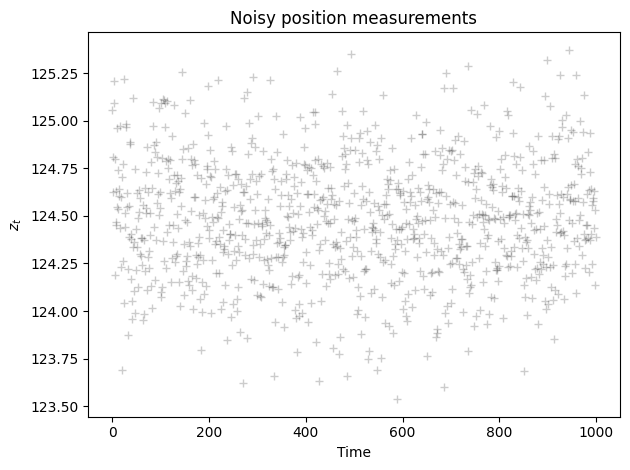

In [4]:
mu = 124.5 # Actual position
R = 0.1    # Actual standard deviation of actual measurements (R)

# Generate measurements
n_measurements = 1000 # Change the number of points to see how the convergence changes
Z = np.random.normal(mu, np.sqrt(R), size=n_measurements)

plt.plot(Z,'k+',label='measurements $z_t$',alpha=0.2)
plt.title('Noisy position measurements')
plt.xlabel('Time')
plt.ylabel('$z_t$')
plt.tight_layout();

- Как обсуждалось ранее, поскольку фактическая ковариация шума измерения неизвестна, мы должны предоставить оценку.
- Обычно это осуществимо, поскольку мы можем оценить $R$ из доступных измерений.
- Кроме того, нам нужно оценить ковариацию шума процесса $Q$, которую обычно сложнее угадать.
- Помните, что $Q$ представляет собой шум модели, используемой для описания фактического положения.
- В нашем случае:

$$x_t = x_0 + w_t \;\; \text{with}\;\; w_t \sim \mathcal{N}(0,Q)$$

- Подводя итог, у нас есть два параметра шума: один для модели ($Q$) и один для измерения ($R$).
- Значения $Q$ и $R$ являются входными данными для алгоритма.
- Поэтому, поскольку мы обычно не используем $Q$ и $R$, нам нужно сделать разумные оценки.

- В этом примере мы знаем фактическую дисперсию для измерений (так как мы сами генерируем измерения).
- Мы можем увидеть эффект от хорошей или плохой оценки этого параметра.
- Кроме того, мы выбираем фактическое положение нашего автомобиля, поэтому мы можем увидеть, как быстро KF сходится к истинному значению.
- Наконец, нам нужно угадать начальные значения для начального положения автомобиля и дисперсию в этой начальной оценке.

In [5]:
# Estimated covariances
Q_est = 1e-4
R_est = 2e-2

- Создайте функцию, которая вычисляет предполагаемое положение и связанную с ним ошибку с использованием KF.

In [6]:
def kalman_1d(x, P, measurement, R_est, Q_est):

    # Prediction
    x_pred = x
    P_pred = P + Q_est

    # Update
    K = P_pred / (P_pred + R_est)
    x_est = x_pred + K * (measurement - x_pred)
    P_est = (1 - K) * P_pred

    return x_est, P_est

- Примените фильтр к статическим измерениям 1D.

In [13]:
# initial guesses
x = 123 # Use an integer (imagine the initial guess is determined with a meter stick)
P = 0.04 # error covariance P

KF_estimate=[] # To store the position estimate at each time point
KF_error=[] # To store estimated error at each time point
for z in Z:
    x, P = kalman_1d(x, P, z, R_est, Q_est)
    KF_estimate.append(x)
    KF_error.append(P)

- Теперь построим график оценки значения $x_t$ поверх измерений $z_t$.
- Мы также построим график того, как оценка ковариации $P_t$ изменяется в ходе процесса.

In [11]:
def plot_1d_comparison(measurements_made, estimate, true_value, axis):
    axis.plot(measurements_made,'k+',label='measurements',alpha=0.3)
    axis.plot(estimate,'-',label='KF estimate')
    if not isinstance(true_value, (list, tuple, np.ndarray)):
        # plot line for a constant value
        axis.axhline(true_value,color='r',label='true value', alpha=0.5)
    else:
        # for a list, tuple or array, plot the points
        axis.plot(true_value,color='r',label='true value', alpha=0.5)
    axis.legend(loc = 'lower right')
    axis.set_title('Estimated position vs. time step')
    axis.set_xlabel('Time')
    axis.set_ylabel('$x_t$')

def plot_1d_error(estimated_error, lower_limit, upper_limit, axis):
    # lower_limit and upper_limit are the lower and upper limits of the vertical axis
    axis.plot(estimated_error, label='KF estimate for $P$')
    axis.legend(loc = 'upper right')
    axis.set_title('Estimated error vs. time step')
    axis.set_xlabel('Time')
    axis.set_ylabel('$P_t$')
    plt.setp(axis,'ylim',[lower_limit, upper_limit])

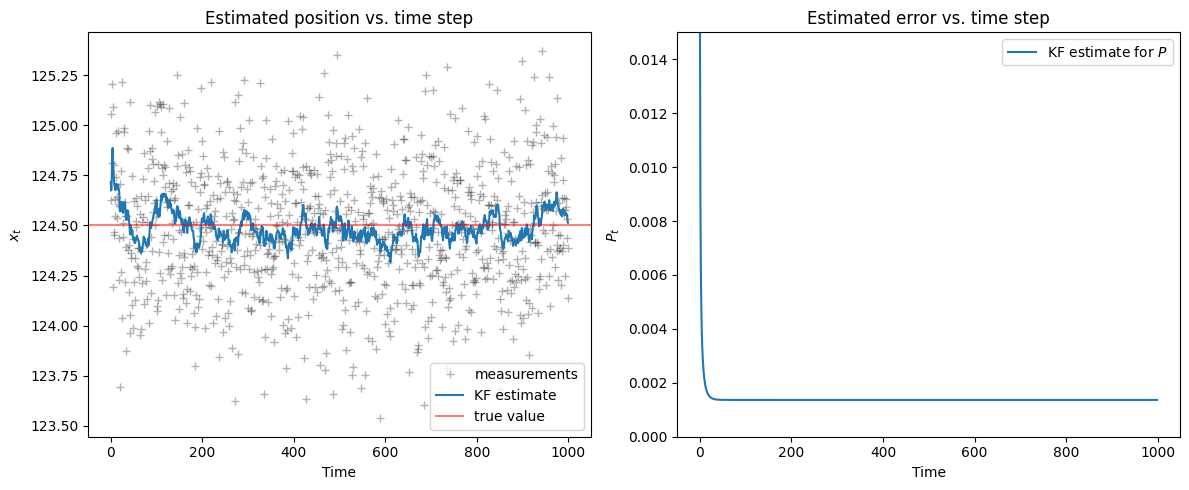

In [12]:
fig, axes = plt.subplots(1,2, figsize=(12, 5))
plot_1d_comparison(Z, KF_estimate, mu, axes[0])
plot_1d_error(KF_error, 0, 0.015, axes[1])
plt.tight_layout();

- Мы видим, что для выбранных нами параметров фильтр быстро сходится к истинному значению, а шум отфильтровывается.

**Вопрос:** Насколько оценка KF колеблется вокруг истинного значения?

**Ответ:** Колебания вокруг истинного значения приблизительно равны размеру стандартного отклонения оценки, которое составляет $\sqrt{P_t}$.

### Пример 2: Динамические одномерные данные

- Давайте теперь рассмотрим систему, которую мы видели ранее, автомобиль, который движется примерно с постоянной скоростью $v_0$.
- Положение меняется со временем согласно следующей формуле:

$$x_{t} = x_{t-1} + \delta t \cdot v_0 + w_t$$

- где $w_t \sim \mathcal{N}(0, Q)$ представляет шум модели.

- Теперь предположим, что у нас есть измерения только для положения, но не для скорости.
- Пусть измерения генерируются в соответствии со следующим распределением:

$$z_t = z_{t-1} + \delta t \cdot v_t$$

- В этом случае $v_t$ представляет собой шумное измерение скорости, которое не наблюдается напрямую.
- Пусть $v_t \sim \mathcal{N}(v_0, R)$, где $R$ представляет собой дисперсию ошибки измерений.

- Давайте теперь изменим наш статический алгоритм, чтобы учесть это движение.
- В каждый момент времени мы будем генерировать случайное значение $v_t$ для измерения скорости.
- Мы предположим, что автомобиль движется со скоростью $v_t$ до следующего момента времени, что позволит нам рассчитать пройденное расстояние.
- Суммируя все пройденные расстояния, мы можем рассчитать измеренное положение автомобиля $z_t$.
- Затем мы применим KF и сравним оценку KF для положения как с фактическим положением $x_t = x_0 + v_0 \cdot t$, так и с измеренным положением $z_t$.

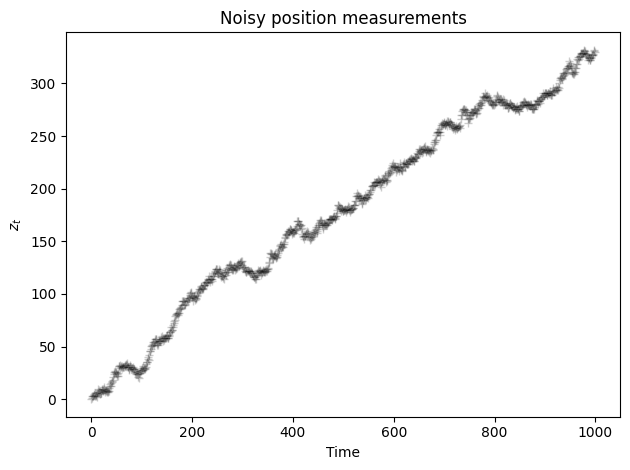

In [14]:
# initial parameters
v0 = 0.3
x0 = 0.0
R = 4.0

# generate noisy measurements
n_measurements = 1000
Zv = np.zeros(n_measurements) # velocity measurements
Zx = np.zeros(n_measurements) # position measurements
for t in range(0, n_measurements-1):
    Zv[t] = np.random.normal(v0, np.sqrt(R))
    Zx[t+1] = Zx[t] + Zv[t] * 1 # delta_t = 1

# generate true positions
Xt = np.zeros(n_measurements)
for t in range(0, n_measurements):
    Xt[t]= x0 + v0*t

plt.plot(Zx,'k+',label='measurements $z_t$',alpha=0.2)
plt.title('Noisy position measurements')
plt.xlabel('Time')
plt.ylabel('$z_t$')
plt.tight_layout();

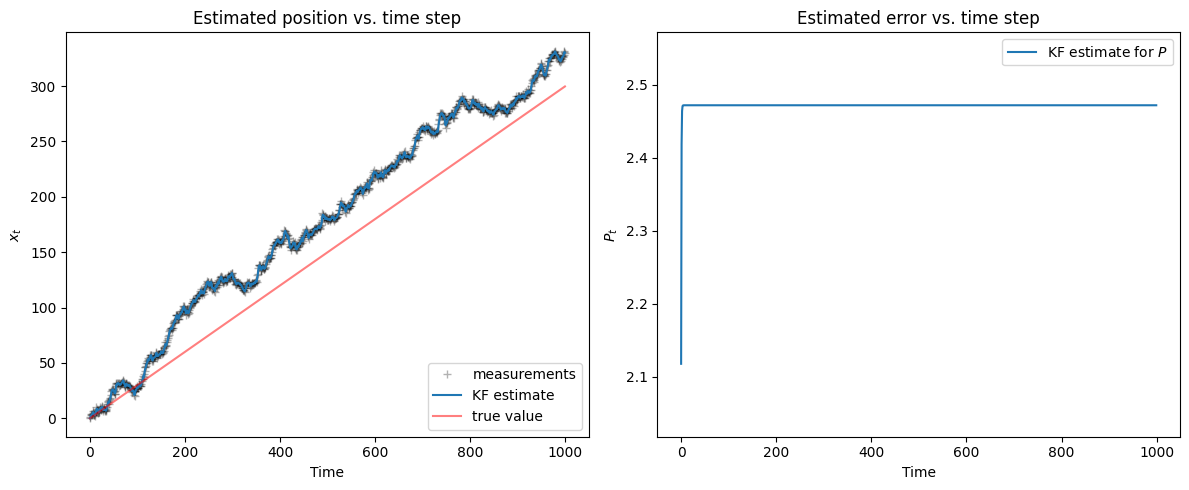

In [15]:
# initial guesses and estimates
x = 0
P = 0.5
Q_est = 4
R_est = 4
KF_estimate = [] # To store the position estimate at each time point
KF_error = [] # To store estimated error at each time point

# Kalman filter
for z in Zx:
    x, P = kalman_1d(x, P, z, R_est, Q_est)
    KF_estimate.append(x)
    KF_error.append(P)

fig, axes = plt.subplots(1,2, figsize=(12, 5))
plot_1d_comparison(Zx, KF_estimate, Xt, axes[0])
plot_1d_error(KF_error, min(KF_error)-0.1, max(KF_error)+0.1, axes[1])
plt.tight_layout();

**Вопрос:** Ни измерения, ни оценка KF не близки к истинному значению. Почему?

**Ответ:** Измерения не близки к истинному значению, поскольку дисперсия ошибки измерений $R$ велика по сравнению со скоростью $v_0$.

- Оценка KF отслеживает измерения, поэтому она не будет близка к истинному значению.
- Кроме того, у нас нет измерений для мгновенной скорости.

- В динамических моделях требуется настраивать больше параметров, поэтому достижение сходимости может быть более сложным.
- Если бы у нас был способ измерения скорости, мы могли бы использовать и эту информацию.
- Тем не менее, KF может работать с неполными наблюдениями, что является одним из его главных преимуществ.

### Пример 3: Динамические двумерные данные

- Теперь рассмотрим пример, который ближе к реальным приложениям: оценка движения точки в двух измерениях, $x$ и $y$.
- Этот 2D-алгоритм используется в программном обеспечении для отслеживания мыши, а также для отслеживания объектов в видео.
- Как и прежде, мы будем использовать мгновенные измерения для положения ($x, y$).
- Мы собираемся использовать фильтр Калмана, встроенный в OpenCV.

Наша система определяется следующими величинами:

- Вектор состояния $\boldsymbol{x} = \begin{bmatrix} x \\ y \\ \dot x \\ \dot y \end{bmatrix}$, представляющий 2D-положение и 2D-скорость.
- Вектор измерения $\boldsymbol{z} = \begin{bmatrix} z_x \\ z_y \end{bmatrix}$, представляющий измерения для 2D-положения.
- Матрица перехода $\mathbf{A} = \begin{bmatrix} 1 & 0 & \delta_t & 0 \\ 0 & 1 & 0 & \delta_t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}$ (называемая `transitionMatrix` в OpenCV).

- Матрица измерений $\mathbf{H} = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \end{bmatrix}$ (в OpenCV называется `measurementMatrix`).

- Ковариация шума модели $\mathbf{Q} = \begin{bmatrix} q & 0 & 0 & 0 \\ 0 & q & 0 & 0 \\ 0 & 0 & q & 0 \\ 0 & 0 & 0 & q \end{bmatrix}$ (называемого `processNoiseCov` в OpenCV).
- Ковариация шума измерений $\mathbf{R} = \begin{bmatrix} r & 0 \\ 0 & r \end{bmatrix}$ (называемого `measurementNoiseCov` в OpenCV).

Для простоты в этом примере мы используем диагональные ковариации.

Конструктор имеет следующий синтаксис:

> `KalmanFilter(state_size, dimensions_size, control_size)`

где:
- `state_size` — размерность вектора состояния $\boldsymbol{x}$, которая в нашем случае равна 4.
- `measurements_size` — размерность вектора состояния $\boldsymbol{x}$, которая в нашем случае равна 2.
- `control_size`, которая равна 0, поскольку у нас нет необязательного элемента управления $\boldsymbol{u}$ (не обсуждается в этой лекции).

In [16]:
kalman = cv2.KalmanFilter(4,2,0) # 4 states, 2 measurements, 0 control vector

q = 1 # the variance in the model
r = 20 # the variance in the measurement
dtime = 1 # size of time step

kalman.measurementMatrix = np.array([[1,0,0,0],
                                     [0,1,0,0]],np.float32) #  H
kalman.transitionMatrix = np.array([[1,0,dtime,0],
                                    [0,1,0,dtime],
                                    [0,0,1,0],
                                    [0,0,0,1]],np.float32) # A
kalman.processNoiseCov = np.array([[1,0,0,0],
                                   [0,1,0,0],
                                   [0,0,1,0],
                                   [0,0,0,1]],np.float32) * q # Q
kalman.measurementNoiseCov = np.array([[1,0],
                                       [0,1]],np.float32) * r # R

KF_estimate_xy = [] # To store the position estimate at each time point

- Далее мы загрузим некоторые предварительно вычисленные данные.

In [17]:
xy_motion = pd.read_csv('https://zenodo.org/records/10951538/files/kf_ts1.csv?download=1',
                        header = None).values.astype('float32')

- Здесь мы используем предварительно вычисленные данные для простоты/воспроизводимости.
- Однако вы можете сгенерировать свои собственные измерения $(z_x, z_y)$, нажав сначала на сетку, а затем на ``Сгенерировать образец``.

In [18]:
from IPython.display import IFrame
IFrame('https://guoguibing.github.io/librec/datagen.html', width=900, height=800)

- Как всегда, взгляните на данные, прежде чем анализировать их.
- Также рекомендуется убедиться, что данные загружены правильно.

In [19]:
print(len(xy_motion))
print(xy_motion[0:10]) # Print first 10 items for clarity, but can look at all 205 or plot them

205
[[2.35 1.45]
 [3.55 1.8 ]
 [3.   2.9 ]
 [2.65 4.2 ]
 [2.95 5.15]
 [3.7  5.4 ]
 [4.8  5.55]
 [5.3  5.25]
 [5.7  5.25]
 [5.8  5.85]]


- Теперь мы готовы применить KF.
- В реализации KF в OpenCV нет параметров инициализации.
- И вектор состояния $\boldsymbol{x}$, и ковариационная матрица $\mathbf{P}$ всегда инициализируются нулем.

In [20]:
for i in xy_motion:
    pred = kalman.predict()  # predicts new state using the model
    kalman.correct((i))      # updates estimated state with the measurement
    KF_estimate_xy.append(((pred[0]),(pred[1]))) # store the estimated position

In [21]:
# Quick check: estimate has same length as measurement data
print(len(KF_estimate_xy))

205


Теперь нанесите данные и оценку KF на график.

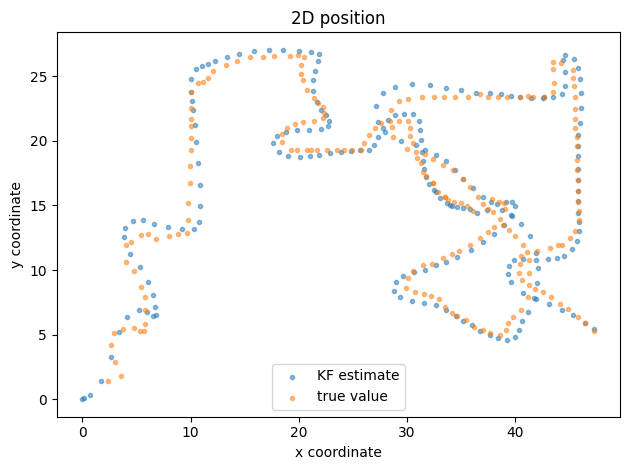

In [22]:
x_est, y_est = zip(*KF_estimate_xy)
x_true, y_true = zip(*xy_motion)
plt.scatter(x_est, y_est, marker= '.', label = 'KF estimate', alpha = 0.5)
plt.scatter(x_true, y_true,marker= '.', label = 'true value', alpha = 0.5)
plt.legend(loc = 'lower center')
plt.title('2D position')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.tight_layout();

- Довольно хорошее согласие.
- Еще раз, вам предлагается изменить параметры и изучить, что произойдет.

---

## Резюме

Что мы рассмотрели на этой практике:

1. Что такое фильтр Калмана
2. Рекурсивная формулировка, используемая для обновления прогнозов.
3. Важность настройки параметров фильтра Калмана.
4. Как применять фильтр Калмана в различных ситуациях.

---

## Упражнения

### Упражнение № 1
Это упражнение относится к [Примеру 1](#example-1-static-one-dimensional-data).
1. Выберите значение для оценочной дисперсии модели `Q_est`, которое больше оценочной дисперсии измерения `R_est`.
2. Повторите анализ Примера 1 для этого нового значения.
3. Сходится ли оценка KF?
4. Почему изменились оценки? Они выглядят более шумными, чем раньше? Почему?

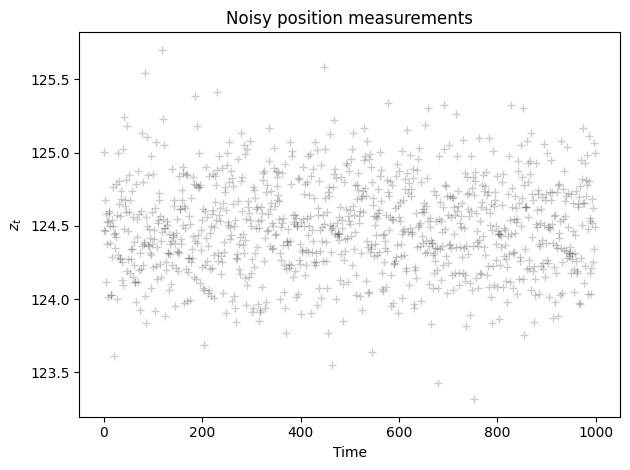

In [24]:
mu = 124.5 # Actual position
R = 0.1    # Actual standard deviation of actual measurements (R)

# Generate measurements
n_measurements = 1000 # Change the number of points to see how the convergence changes
Z = np.random.normal(mu, np.sqrt(R), size=n_measurements)

plt.plot(Z,'k+',label='measurements $z_t$',alpha=0.2)
plt.title('Noisy position measurements')
plt.xlabel('Time')
plt.ylabel('$z_t$')
plt.tight_layout();

In [41]:
# Estimated covariances
Q_est = 2e-1
R_est = 2e-2

In [42]:
# initial guesses
x = 123 # Use an integer (imagine the initial guess is determined with a meter stick)
P = 0.04 # error covariance P

KF_estimate=[] # To store the position estimate at each time point
KF_error=[] # To store estimated error at each time point
for z in Z:
    x, P = kalman_1d(x, P, z, R_est, Q_est)
    KF_estimate.append(x)
    KF_error.append(P)

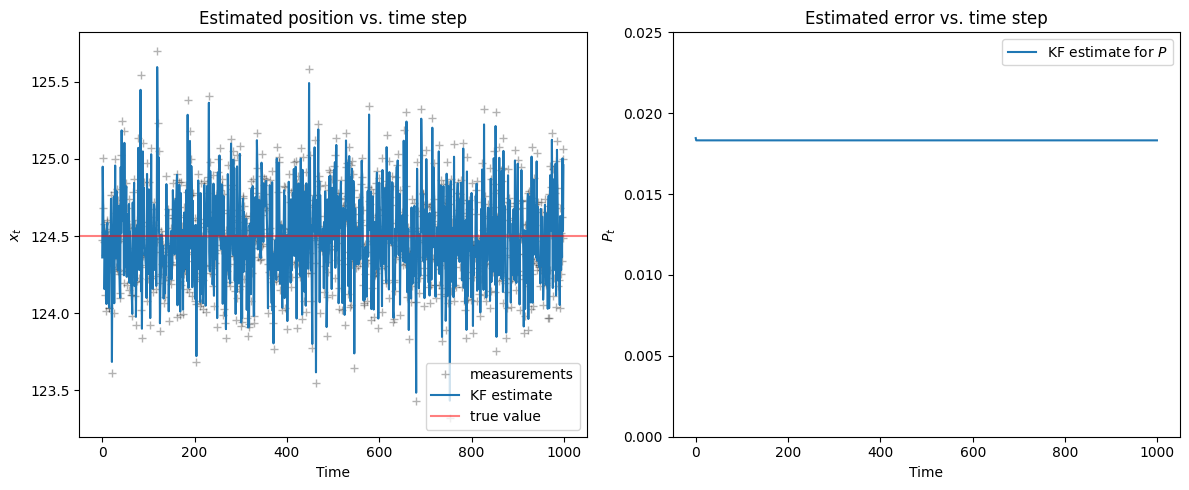

In [43]:
fig, axes = plt.subplots(1,2, figsize=(12, 5))
plot_1d_comparison(Z, KF_estimate, mu, axes[0])
plot_1d_error(KF_error, 0, 0.025, axes[1])
plt.tight_layout();

Фильтр все еще пытается отслеживать истинное значение, однако его оценка теперь намного более "шумная" и следует за измерениями гораздо сильнее.

Фильтр доверяет измерениям гораздо больше, чем своему собственному прогнозу. Поэтому оценка KF начинает "прыгать" вслед за каждым новым измерением.

### Упражнение №2

Это упражнение относится к [Примеру 2](#example-2-dynamic-one-dimensional-data).

В случае, который мы рассмотрели выше, оценка KF была близка к измерениям, и оба отличались от истинного значения.
Изменяйте параметры алгоритма, пока не найдете некоторые комбинации, которые достигают следующего:

1. Измерения, оценка KF и истинное значение все близки.
2. Измерения, оценка KF и истинное значение все заметно отличаются.
3. Измерения близки к истинному значению, но оценка KF отличается.

Обсудите свои выводы.

### 1. Измерения, оценка KF и истинное значение все близки.

Для этого уменьшим R (или сделаем 0), чтобы минимизировать шум.

R_est << Q_est чтобы измерения сильно влияли на оценку.

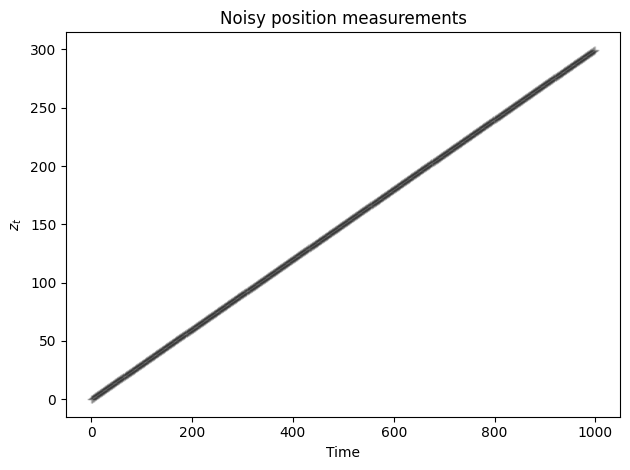

In [119]:
# initial parameters
v0 = 0.3
x0 = 0.0
R = 0

# generate noisy measurements
n_measurements = 1000
Zv = np.zeros(n_measurements) # velocity measurements
Zx = np.zeros(n_measurements) # position measurements
for t in range(0, n_measurements-1):
    Zv[t] = np.random.normal(v0, np.sqrt(R))
    Zx[t+1] = Zx[t] + Zv[t] * 1 # delta_t = 1

# generate true positions
Xt = np.zeros(n_measurements)
for t in range(0, n_measurements):
    Xt[t]= x0 + v0*t

plt.plot(Zx,'k+',label='measurements $z_t$',alpha=0.2)
plt.title('Noisy position measurements')
plt.xlabel('Time')
plt.ylabel('$z_t$')
plt.tight_layout();

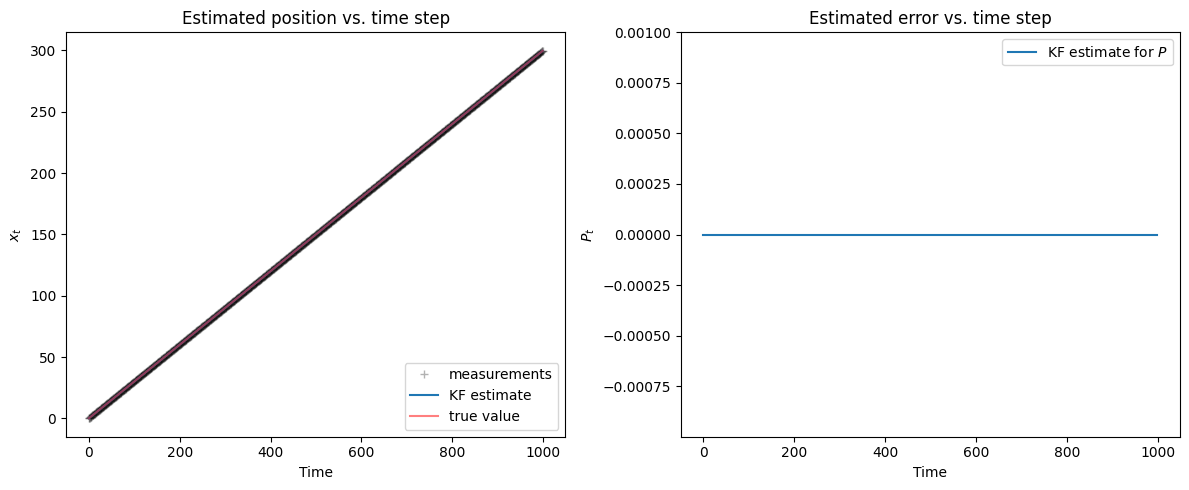

In [121]:
# initial guesses and estimates
x = 0
P = 0.5
Q_est = 2e-1
R_est = 2e-8
KF_estimate = [] # To store the position estimate at each time point
KF_error = [] # To store estimated error at each time point

# Kalman filter
for z in Zx:
    x, P = kalman_1d(x, P, z, R_est, Q_est)
    KF_estimate.append(x)
    KF_error.append(P)

fig, axes = plt.subplots(1,2, figsize=(12, 5))
plot_1d_comparison(Zx, KF_estimate, Xt, axes[0])
plot_1d_error(KF_error, min(KF_error)-0.001, max(KF_error)+0.001, axes[1])
plt.tight_layout();

### 2. Измерения, оценка KF и истинное значение все заметно отличаются.

R берем большим, чтобы создать шум и отличия между измерениями и истинным значением.

Q_est << R_est. Q_est намного меньше R_est, чтобы измерения минимально влияли.

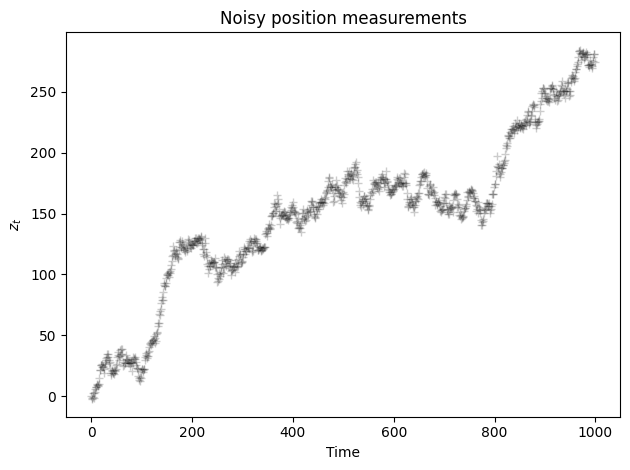

In [127]:
# initial parameters
v0 = 0.3
x0 = 0.0
R = 10

# generate noisy measurements
n_measurements = 1000
Zv = np.zeros(n_measurements) # velocity measurements
Zx = np.zeros(n_measurements) # position measurements
for t in range(0, n_measurements-1):
    Zv[t] = np.random.normal(v0, np.sqrt(R))
    Zx[t+1] = Zx[t] + Zv[t] * 1 # delta_t = 1

# generate true positions
Xt = np.zeros(n_measurements)
for t in range(0, n_measurements):
    Xt[t]= x0 + v0*t

plt.plot(Zx,'k+',label='measurements $z_t$',alpha=0.2)
plt.title('Noisy position measurements')
plt.xlabel('Time')
plt.ylabel('$z_t$')
plt.tight_layout();

0.00020653529083431197


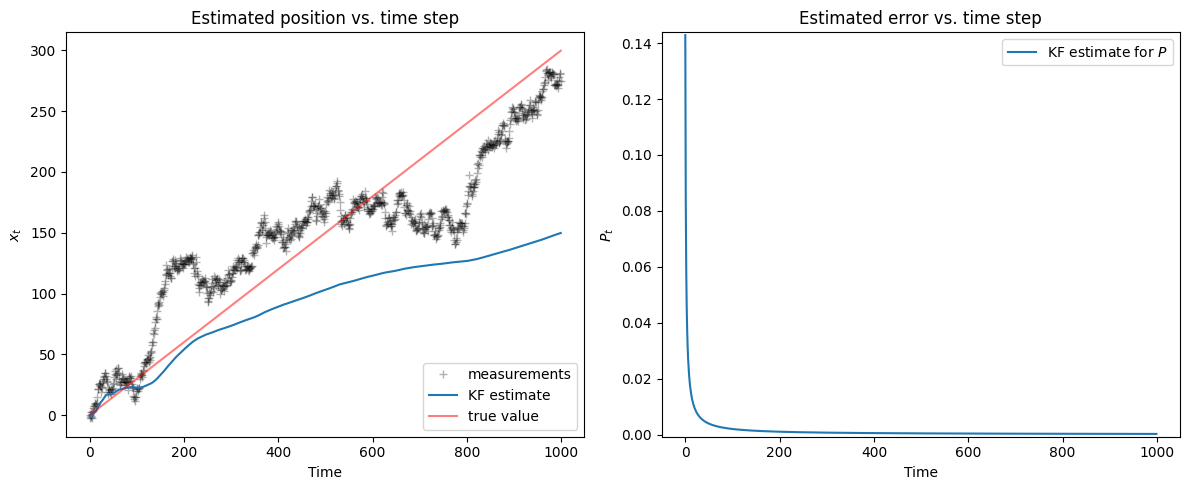

In [128]:
# initial guesses and estimates
x = 0
P = 0.5
Q_est = 2e-8
R_est = 2e-1
KF_estimate = [] # To store the position estimate at each time point
KF_error = [] # To store estimated error at each time point

# Kalman filter
for z in Zx:
    x, P = kalman_1d(x, P, z, R_est, Q_est)
    KF_estimate.append(x)
    KF_error.append(P)

fig, axes = plt.subplots(1,2, figsize=(12, 5))
plot_1d_comparison(Zx, KF_estimate, Xt, axes[0])
plot_1d_error(KF_error, min(KF_error)-0.001, max(KF_error)+0.001, axes[1])
plt.tight_layout();

print(KF_error[-1])

### 3. Измерения близки к истинному значению, но оценка KF отличается

R берем небольшим, чтобы минимизировать шум и измерения были близки к истинным значениям.

Q_est << R_est. Q_est намного меньше R_est, чтобы измерения минимально влияли.

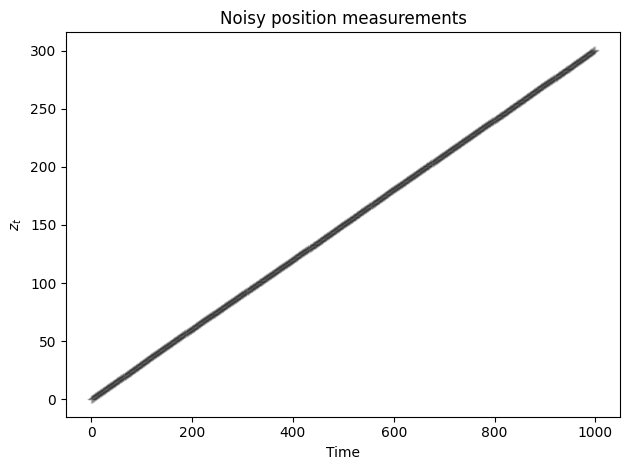

In [129]:
# initial parameters
v0 = 0.3
x0 = 0.0
R = 0.001

# generate noisy measurements
n_measurements = 1000
Zv = np.zeros(n_measurements) # velocity measurements
Zx = np.zeros(n_measurements) # position measurements
for t in range(0, n_measurements-1):
    Zv[t] = np.random.normal(v0, np.sqrt(R))
    Zx[t+1] = Zx[t] + Zv[t] * 1 # delta_t = 1

# generate true positions
Xt = np.zeros(n_measurements)
for t in range(0, n_measurements):
    Xt[t]= x0 + v0*t

plt.plot(Zx,'k+',label='measurements $z_t$',alpha=0.2)
plt.title('Noisy position measurements')
plt.xlabel('Time')
plt.ylabel('$z_t$')
plt.tight_layout();

0.00020653529083431197


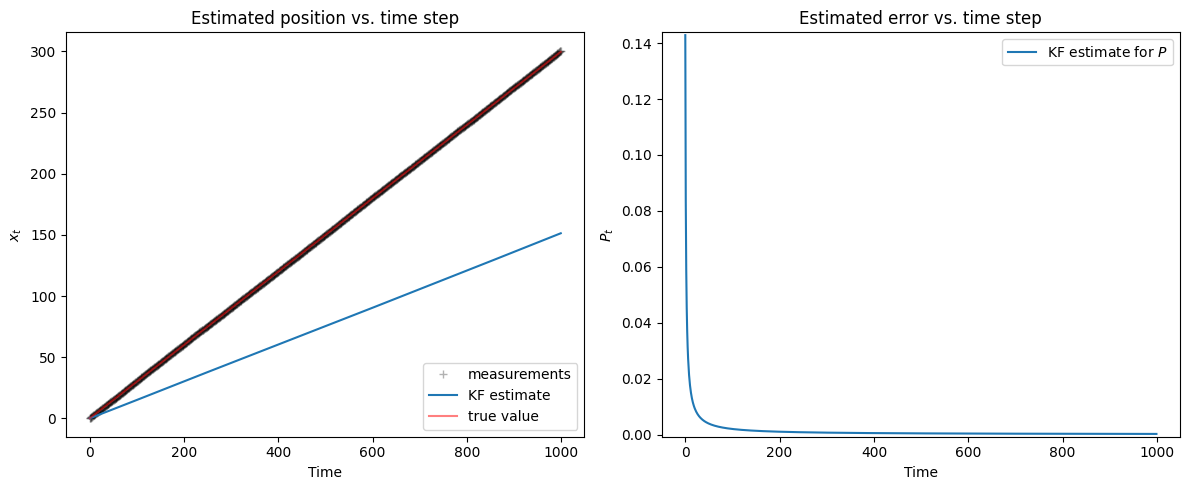

In [130]:
# initial guesses and estimates
x = 0
P = 0.5
Q_est = 2e-8
R_est = 2e-1
KF_estimate = [] # To store the position estimate at each time point
KF_error = [] # To store estimated error at each time point

# Kalman filter
for z in Zx:
    x, P = kalman_1d(x, P, z, R_est, Q_est)
    KF_estimate.append(x)
    KF_error.append(P)

fig, axes = plt.subplots(1,2, figsize=(12, 5))
plot_1d_comparison(Zx, KF_estimate, Xt, axes[0])
plot_1d_error(KF_error, min(KF_error)-0.001, max(KF_error)+0.001, axes[1])
plt.tight_layout();

print(KF_error[-1])

### Упражнение №3

Это упражнение относится к [Примеру 3](#example-3-dynamic-two-dimensional-data).

В исходном примере мы использовали и Положение, и Скорость (модель PV) в векторе состояния, т. е. $\boldsymbol{x} = \begin{bmatrix} x & y & \dot x & \dot y \end{bmatrix}^T$.

Что произойдет, если мы используем только Положение (модель P) для описания состояния? В конце концов, наши измерения предоставляют только положение. Действительно ли нам нужно включать скорость?

1. Перепишите алгоритм выше для модели P.

**💡 Подсказка:** каков размер вектора состояния в этом случае? Каковы размерности матриц, характеризующих систему?

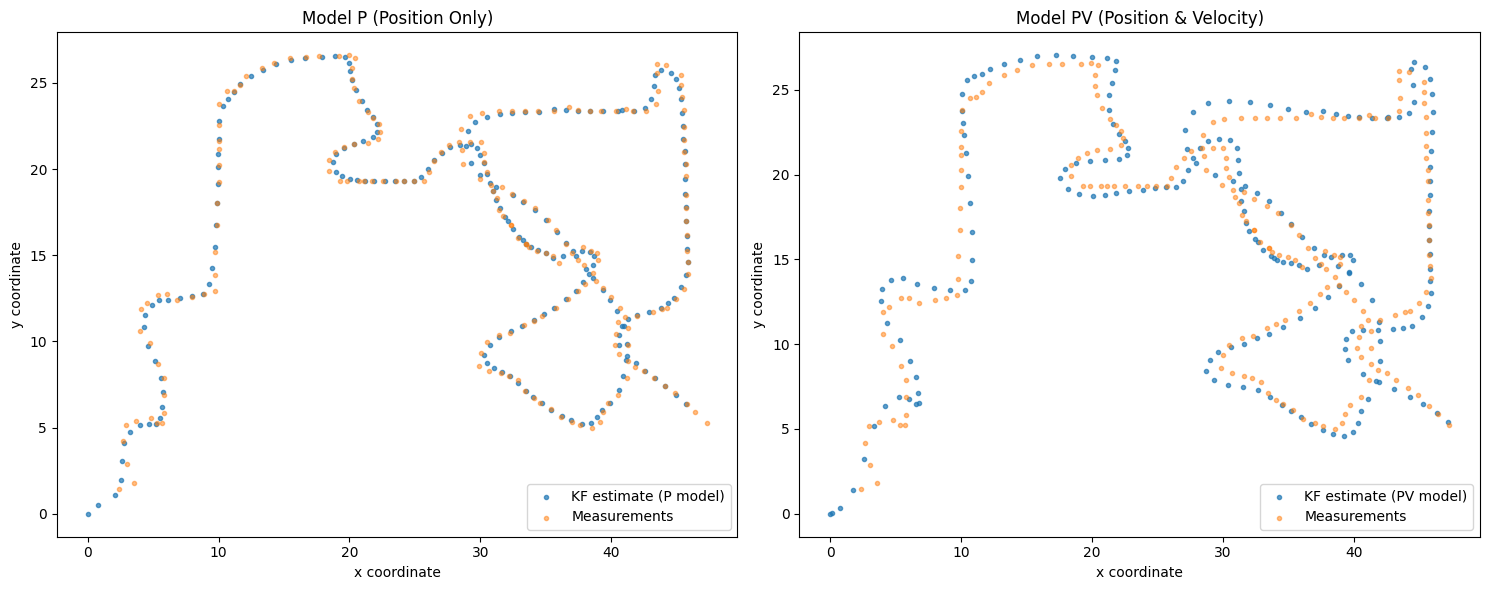

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# Загрузка данных
xy_motion = pd.read_csv('https://zenodo.org/records/10951538/files/kf_ts1.csv?download=1',
                        header=None).values.astype('float32')

# --- Настройка фильтра Калмана для модели P (Только Положение) ---
kalman_p = cv2.KalmanFilter(2, 2, 0)  # 2 состояния (x, y), 2 измерения (x, y)

q_p = 10.0
r_p = 20.0  # Дисперсия измерения (остается прежней)
# dtime не нужен, так как модель не использует скорость

# Матрица измерений H: измеряем x и y напрямую
kalman_p.measurementMatrix = np.array([[1, 0],
                                       [0, 1]], np.float32)

# Матрица перехода A: следующее положение = текущее положение
kalman_p.transitionMatrix = np.array([[1, 0],
                                      [0, 1]], np.float32)

# Ковариационная матрица шума процесса Q
kalman_p.processNoiseCov = np.array([[1, 0],
                                     [0, 1]], np.float32) * q_p

# Ковариационная матрица шума измерений R
kalman_p.measurementNoiseCov = np.array([[1, 0],
                                         [0, 1]], np.float32) * r_p

# --- Применение фильтра ---
KF_estimate_xy_p = []

for measurement in xy_motion:
    pred = kalman_p.predict()
    kalman_p.correct(measurement)
    KF_estimate_xy_p.append((pred[0], pred[1]))

# --- Визуализация для сравнения ---
# Сначала получим результаты исходной PV-модели для сравнения
kalman_pv = cv2.KalmanFilter(4,2,0)
q_pv = 1
r_pv = 20
dtime = 1

kalman_pv.measurementMatrix = np.array([[1,0,0,0],
                                        [0,1,0,0]],np.float32)
kalman_pv.transitionMatrix = np.array([[1,0,dtime,0],
                                       [0,1,0,dtime],
                                       [0,0,1,0],
                                       [0,0,0,1]],np.float32)
kalman_pv.processNoiseCov = np.array([[1,0,0,0],
                                      [0,1,0,0],
                                      [0,0,1,0],
                                      [0,0,0,1]],np.float32) * q_pv
kalman_pv.measurementNoiseCov = np.array([[1,0],
                                          [0,1]],np.float32) * r_pv

KF_estimate_xy_pv = []
for i in xy_motion:
    pred = kalman_pv.predict()
    kalman_pv.correct(i)
    KF_estimate_xy_pv.append(((pred[0]),(pred[1])))

# Построение графиков
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# График для модели P (Только Положение)
x_est_p, y_est_p = zip(*KF_estimate_xy_p)
x_true, y_true = zip(*xy_motion)
axes[0].scatter(x_est_p, y_est_p, marker='.', label='KF estimate (P model)', alpha=0.7)
axes[0].scatter(x_true, y_true, marker='.', label='Measurements', alpha=0.5)
axes[0].legend()
axes[0].set_title('Model P (Position Only)')
axes[0].set_xlabel('x coordinate')
axes[0].set_ylabel('y coordinate')

# График для модели PV (Положение и Скорость)
x_est_pv, y_est_pv = zip(*KF_estimate_xy_pv)
axes[1].scatter(x_est_pv, y_est_pv, marker='.', label='KF estimate (PV model)', alpha=0.7)
axes[1].scatter(x_true, y_true, marker='.', label='Measurements', alpha=0.5)
axes[1].legend()
axes[1].set_title('Model PV (Position & Velocity)')
axes[1].set_xlabel('x coordinate')
axes[1].set_ylabel('y coordinate')

plt.tight_layout()
plt.show()

Размер состояния станет 2.

Матрицы станут единичными матрицами 2x2.

Нужно включать скорость. Несмотря на то, что измеряется только положение, скорость в модели состояния дает фильтру физическую модель движения, что критически важно для точного и плавного отслеживания движущихся объектов.